In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from skimage.io import imread, imshow

In [4]:
YOLO_MODELS_PATH = "yolo_models/"
TRAIN_PATH = '../../data/raw_data/malaria/transformed_images/'

MASK_CATEGORIES = ['trophozoite','ring', 'schizont', 'gametocyte']
STR_MASK_CATEGORIES = '_'.join(MASK_CATEGORIES)


## YOLO MODEL PREDICTIONS

In [61]:
def yolo_model_prediction(model_path, classes_file, model_file, weigths_file, inputs, input_width, input_height, conf_threshold = 0.4, generate_mask = True):
    '''
    model_path     :path of classes_file, model_file, weigths_file 
    classes_file   :this file contains a list of the object classes
    model_file     :cfg file
    weigths_file   :weigths file
    inputs
    '''
    
    # Load model
    net = cv2.dnn.readNetFromDarknet(model_path + model_file, model_path + weigths_file)
    
    # outputs initialization
    count  = 0
    tested = 0
    #img_index = 0
    class_ids = []
    confidences = []
    boxes = []
    images_index = []
    masks = []
    
    for img_index,i in enumerate(inputs):
        tested += 1
        image = cv2.imread(i)
        Width = image.shape[1]
        Height = image.shape[0]
        scale = 1/255

        blob = cv2.dnn.blobFromImage(image, scale, (input_width,input_height),  [0,0,0],swapRB=True, crop=False)

        net.setInput(blob)

        layer_names = net.getLayerNames()
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

        outs = net.forward(output_layers)
        
        ## MASK ##
        if (generate_mask):
            masks.append(np.zeros((input_width, input_height), dtype=np.uint8))
        ##########


        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]

                if confidence >= conf_threshold:
                    center_x = int(detection[0] * Width)
                    center_y = int(detection[1] * Height)
                    w = int(detection[2] * Width)
                    h = int(detection[3] * Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])
                    #print("confidence: {:.2f}, class: {:.2f} \n ".format(confidence, class_id))
                    images_index.append(img_index)
                    
                    ## MASK ##
                    if (generate_mask):
                        current_mask = masks[img_index]
                        current_mask[slice(round(x), round(x+w)), slice(round(y), round(y+h))] = 1
                        masks[img_index] = current_mask     
                    ##########
                    count +=1
                    

        #img_index+=1

    print("####### RESULTS ########")
    print("Total images tested: {}, Number of detections: {}".format(tested, count))

    
    return class_ids, confidences, boxes, images_index, masks

In [7]:
train_ids = np.load(TRAIN_PATH+'malaria_train_transformed_256_256_names.npy',allow_pickle=True)
test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy',allow_pickle=True)

In [70]:
model_file = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_1024_1024.cfg'
weigths_file = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_1024_1024_best.weights'

In [71]:
class_ids, confidences, boxes, images_index, masks = yolo_model_prediction(YOLO_MODELS_PATH, \
                                                                    "obj_es.names", model_file, weigths_file, \
                                                                    test_ids, 1024, 1024, conf_threshold = 0.4)

####### RESULTS ########
Total images tested: 120, Number of detections: 106


In [72]:
model_file2 = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_512_512.cfg'
weigths_file2 = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_512_512_best.weights'

In [73]:
class_ids2, confidences2, boxes2, images_index2, masks2 = yolo_model_prediction(YOLO_MODELS_PATH, \
                                                                                "obj_es.names", model_file2, \
                                                                                weigths_file2, test_ids, \
                                                                                512, 512, conf_threshold = 0.4)

####### RESULTS ########
Total images tested: 120, Number of detections: 60


In [38]:
### count classes ##
from collections import Counter

Counter(class_ids)

Counter({0: 106})

In [ ]:
Counter

### Generate masks for YOLO output

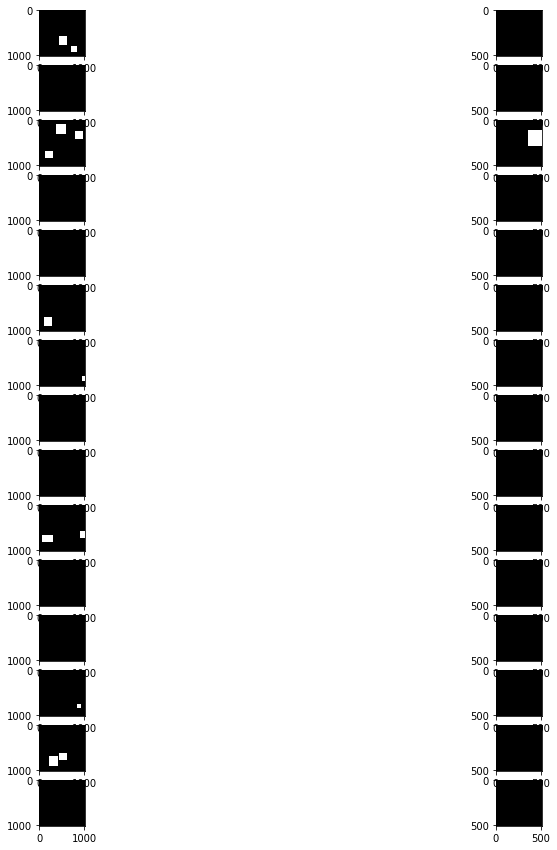

In [74]:
fig, axes = plt.subplots(15,2,figsize=(15,15))

for img_id, mask in enumerate(masks[:15]):
    axes[img_id,0].imshow(mask, cmap='gray')
    axes[img_id,1].imshow(masks2[img_id], cmap='gray')

In [17]:
# generate different colors for different classes 
with open(YOLO_MODELS_PATH+"obj_es.names", 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 4))

In [18]:
#model_file = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_512_512.cfg'
#weigths_file = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_512_512_best.weights'

model_file = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_1024_1024.cfg'
weigths_file = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_1024_1024_best.weights'

In [19]:
net = cv2.dnn.readNetFromDarknet(YOLO_MODELS_PATH + model_file, YOLO_MODELS_PATH + weigths_file)

In [20]:
#net = cv2.dnn.readNet(YOLO_MODELS_PATH + "YOLO-malaria_201908112336_trophozoite_ring_schizont_gametocyte_800_800_best.weights", \
#                      YOLO_MODELS_PATH+"YOLO-malaria_201908112336_trophozoite_ring_schizont_gametocyte_800_800.cfg")

In [21]:
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [22]:
net

<dnn_Net 0x7efd64f13c30>

In [23]:
# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

### Read Image

In [24]:
test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy',allow_pickle=True)
Y_test =  np.load(TRAIN_PATH+'malaria_test_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)

In [25]:
train_ids = np.load(TRAIN_PATH+'malaria_train_transformed_256_256_names.npy',allow_pickle=True)

In [13]:
#image = cv2.imread(test_ids[n])
count =0
tested = 0
im_id=0

# outputs initialization
count  = 0
tested = 0
img_id = 0
class_ids = []
confidences = []
boxes = []
images_ids = []
    
for im in train_ids:
    tested += 1
    image = cv2.imread(im)
    Width = image.shape[1]
    Height = image.shape[0]
    scale = 1/255


    blob = cv2.dnn.blobFromImage(image, scale, (800,800),  [0,0,0],swapRB=True, crop=False)
    
    net.setInput(blob)
    
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    outs = net.forward(output_layers)
    

    conf_threshold = 0.5
    nms_threshold = 0.4

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if confidence > 0.:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
                #print("confidence: {:.2f}, class: {:.2f} \n ".format(confidence, class_id))
                images_ids.append(im_id)
                count +=1
                
    im_id+=1

print("####### RESULTS ########")
print("Total images tested: {}, Number of detections: {}".format(tested, count))

####### RESULTS ########
Total images tested: 1208, Number of detections: 2141


In [73]:
images_dict = {}
images_name = {}

for i,box in enumerate(boxes):
    im_id = images_ids[i]
    im_name = test_ids[im_id]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    if im_id in images_dict:
        img = images_dict[im_id]
        draw_bounding_box(img, class_ids[i], 0.4, round(x), round(y), round(x+w), round(y+h))
    
    else:
        img = cv2.imread(test_ids[im_id])
        draw_bounding_box(img, class_ids[i], 0.4, round(x), round(y), round(x+w), round(y+h))
        images_dict[im_id] = img
        images_name[im_id] = im_name[35:-4]
        
    
    


In [74]:
for id, image in images_dict.items():
       
    # save output image to disk 
    cv2.imwrite(images_name[id] + "_yolo_pred.jpg", image)


In [15]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

In [ ]:

for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

    # display output image    
    #cv2.imshow("object detection", image)

    # wait until any key is pressed
    #cv2.waitKey()
    
    # save output image to disk 
    cv2.imwrite("object-detection.jpg", image)

    # release resources
    cv2.destroyAllWindows()

0


In [ ]:
class_ids